In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import periodogram, welch
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [20,10]

In [120]:
def visualize_time_series(time_series, name, nlags=52, rolling=12, n_format=',.0f', nperseq=100, period=52):
    fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(10,30))
    ax.ravel()
    mean = time_series.rolling(rolling).mean()
    std = time_series.rolling(rolling).std()
    realization_plot = sns.lineplot(data=time_series, ax=ax[0], ci=None, label='Realization')
    sns.lineplot(data=mean, color='red', ax=ax[0], ci=None, label=f'{rolling} Period MA')
    realization_plot.lines[1].set_linestyle('--')
    sns.lineplot(data=std, color='green', ax=ax[0], ci=None, label=f'{rolling} Period Volatility')
    realization_plot.lines[2].set_linestyle('--')
    
    realization_plot.set_title(f'Realization: {name}')
    realization_plot.set_yticklabels([f'{str(y).format(n_format)}' for y in realization_plot.get_yticks()])
    
    acf = sm.tsa.acf(time_series.dropna(), nlags=nlags, fft=False)
    pacf = sm.tsa.pacf_ols(time_series.dropna(), nlags=nlags)
    acf = sns.barplot(data=pd.DataFrame({'lag':range(1, len(acf)),
                          'acf':acf[1:]}), x='lag', y='acf', ax=ax[1], color='blue', alpha=0.2)
    pacf = sns.barplot(data=pd.DataFrame({'lag':range(1, len(pacf)),
                          'pacf':pacf[1:]}), x='lag', y='pacf', ax=ax[2], color='blue', alpha=0.2)
    period_gram = welch(time_series, scaling='spectrum', nperseg=nperseq)
    max_freq = period_gram[0][period_gram[1].argmax()]
    period_gram = sns.lineplot(data=pd.DataFrame({'frequency':period_gram[0],
                          'power':period_gram[1]/max(period_gram[1])}), x='frequency', y='power', ax=ax[3])
    acf.axhline(y=-1.96/np.sqrt(len(time_series)),linestyle='--',color='gray')
    acf.axhline(y=1.96/np.sqrt(len(time_series)),linestyle='--',color='gray')
    pacf.axhline(y=-1.96/np.sqrt(len(time_series)),linestyle='--',color='gray')
    pacf.axhline(y=1.96/np.sqrt(len(time_series)),linestyle='--',color='gray')

    
    acf.set_title(f'ACF: {name}')
    pacf.set_title(f'PACF: {name}')
    period_gram.set_title(f'Spectral Density: Peak {round(max_freq, 3)} Hz - Window: {nperseq}')
    pacf.set_xticklabels(pacf.get_xticklabels(),rotation=-45)
    acf.set_xticklabels(acf.get_xticklabels(),rotation=-45)
    period_gram.set_yscale('log')
    fig.subplots_adjust(hspace=0.3)
    fig.tight_layout()
    time_series.index = pd.DatetimeIndex(time_series.index, freq='infer')
    decomposition = sm.tsa.seasonal_decompose(time_series.dropna(), model='additive', period=period)
    trend = sns.lineplot(data=decomposition.trend, color='black', ax=ax[4], ci=None, label=f'{name} - Trend')
    seasonal = sns.lineplot(data=decomposition.seasonal, color='black', ax=ax[5], ci=None, label=f'{name} - Seasonal')
    residuals = sns.lineplot(data=decomposition.resid, color='black', ax=ax[6], ci=None, label=f'{name} - Residual')
    trend.set_title(f'{name} - Trend')
    seasonal.set_title(f'{name} - Seasonality for Periodicity {period}')
    residuals.set_title(f'{name} - Residuals')
    
    return decomposition

def fit_time_series(time_series, max_ar=6, max_ma=4, seasonal=52):
    model_select = sm.tsa.arma_order_select_ic(y=time_series, ic=['aic', 'bic'], trend='nc', max_ar=max_ar, max_ma=max_ma)
    aic_select = model_select['aic_min_order']
    bic_select = model_select['bic_min_order']
    print(f'AIC selects: AR({aic_select[0]}) MA({aic_select[1]})')
    print(f'BIC selects: AR({bic_select[0]}) MA({bic_select[1]})')
    model_aic = sm.tsa.arima.ARIMA(endog=time_series, order=(aic_select[0], 0, aic_select[1]), trend='n')
    aic_fit = model_aic.fit()
    model_bic = sm.tsa.arima.ARIMA(endog=time_series, order=(bic_select[0], 0, bic_select[1]), trend='n')
    bic_fit = model_bic.fit()
    model_seasonal = sm.tsa.arima.ARIMA(endog=time_series, seasonal_order=(0, 0, 0, seasonal), trend='n')
    seasonal_fit = model_seasonal.fit()
    return aic_fit, bic_fit, seasonal_fit

### Load Data

In [137]:
data = pd.read_csv('FluNetInteractiveReport.csv')
data_nas = data.describe()

***Parse Dates to Datetime***

In [138]:
data['SDATE'] = pd.to_datetime(data['SDATE'])
data['EDATE'] = pd.to_datetime(data['EDATE'])

***Convert to Categoricals***

In [139]:
categoricals = data.columns[data.dtypes == 'object']
categoricals

Index(['Country', 'WHOREGION', 'FLUREGION', 'TITLE'], dtype='object')

In [140]:
for x in categoricals:
    data[x] = data[x].astype('category')

***Set Index to EDATE***

In [141]:
data.set_index(['EDATE'], inplace=True)

In [142]:
numerics = data.columns[data.dtypes == 'float']

Dropping observations from Bermuda (modeling choice) and only keeping data from 2017 onwards per the client warnings on data integrity for previous periods.

In [143]:
data = data[data.Country != 'Bermuda']
data = data[data.index.year.isin([2016, 2017, 2018, 2019, 2020])]
train_data = data[data.index.year.isin([2016, 2017, 2018])]
test_data = data[data.index.year.isin([2019, 2020])]

In [144]:
train_data.describe()

,Year,Week,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2
count,314.000000,314.000000,314.000000,314.000000,185.0,314.000000,314.000000,28.0,314.000000,314.000000,185.000000,185.000000,314.000000,314.000000,314.000000,157.000000
mean,2016.987261,26.668790,14808.226115,14808.226115,0.0,141.700637,316.363057,0.0,1236.563694,1694.627389,113.789189,29.518919,619.808917,704.242038,2398.869427,20274.974522
std,0.830622,15.132382,16001.626435,16001.626435,0.0,321.298871,632.146656,0.0,2682.974338,3357.210652,196.236115,44.495370,1217.922670,1394.685146,4486.993892,12491.155683
min,2015.000000,1.000000,1515.000000,1515.000000,0.0,0.000000,1.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5917.000000
25%,2016.000000,14.000000,4507.750000,4507.750000,0.0,3.000000,16.000000,0.0,40.000000,66.000000,3.000000,0.000000,20.250000,21.000000,116.000000,9777.000000
50%,2017.000000,27.000000,8809.000000,8809.000000,0.0,13.000000,54.000000,0.0,178.000000,302.500000,13.000000,6.000000,103.000000,115.000000,559.500000,18481.000000
75%,2018.000000,40.000000,19578.750000,19578.750000,0.0,73.000000,235.500000,0.0,1139.000000,1831.750000,131.000000,43.000000,594.000000,647.000000,2505.750000,27014.000000
max,2018.000000,53.000000,88743.000000,88743.000000,0.0,2173.000000,3336.000000,0.0,16672.000000,19961.000000,931.000000,193.000000,8461.000000,9507.000000,26386.000000,62357.000000


In [145]:
test_data.describe()

,Year,Week,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2
count,156.000000,156.000000,152.000000,152.000000,52.0,152.000000,152.000000,0.0,152.000000,152.000000,75.000000,75.000000,152.000000,152.000000,152.000000,75.000000
mean,2019.333333,22.166667,21545.328947,21545.328947,0.0,344.690789,174.052632,NaN,2176.125000,2694.868421,7.946667,209.613333,1032.381579,1139.730263,3834.598684,27936.986667
std,0.472923,14.415419,21171.057522,21171.057522,0.0,557.457916,347.933574,NaN,3835.904843,4589.034427,8.048658,360.276316,2274.629541,2541.757313,6273.503074,16275.956672
min,2019.000000,1.000000,1928.000000,1928.000000,0.0,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4440.000000
25%,2019.000000,10.000000,7794.250000,7794.250000,0.0,10.750000,18.750000,NaN,43.000000,77.000000,0.500000,14.500000,31.000000,31.000000,112.500000,12204.000000
50%,2019.000000,20.000000,12546.500000,12546.500000,0.0,41.000000,60.500000,NaN,273.000000,409.000000,7.000000,40.000000,154.000000,164.000000,702.000000,26442.000000
75%,2020.000000,33.000000,27616.250000,27616.250000,0.0,403.500000,120.500000,NaN,1747.750000,2291.500000,13.000000,146.500000,617.750000,702.000000,3819.500000,40908.500000
max,2020.000000,52.000000,78277.000000,78277.000000,0.0,2339.000000,1829.000000,NaN,13759.000000,16740.000000,31.000000,1309.000000,11587.000000,12920.000000,25630.000000,67857.000000


![Data Dictionary](datadefinitions.jpeg)

### Address Stationarity

- Condition 1: Is the mean time-dependent?

- Condition 2: Is there evidence of heteroskesdacity?

- Condition 3: Are observations independent (i.e not serially correlated)

SPEC_RECEIVED_NB
SPEC_PROCESSED_NB
AH1
AH1N12009
AH3
AH5
ANOTSUBTYPED
INF_A
BYAMAGATA
BVICTORIA
BNOTDETERMINED
INF_B
ALL_INF
ALL_INF2


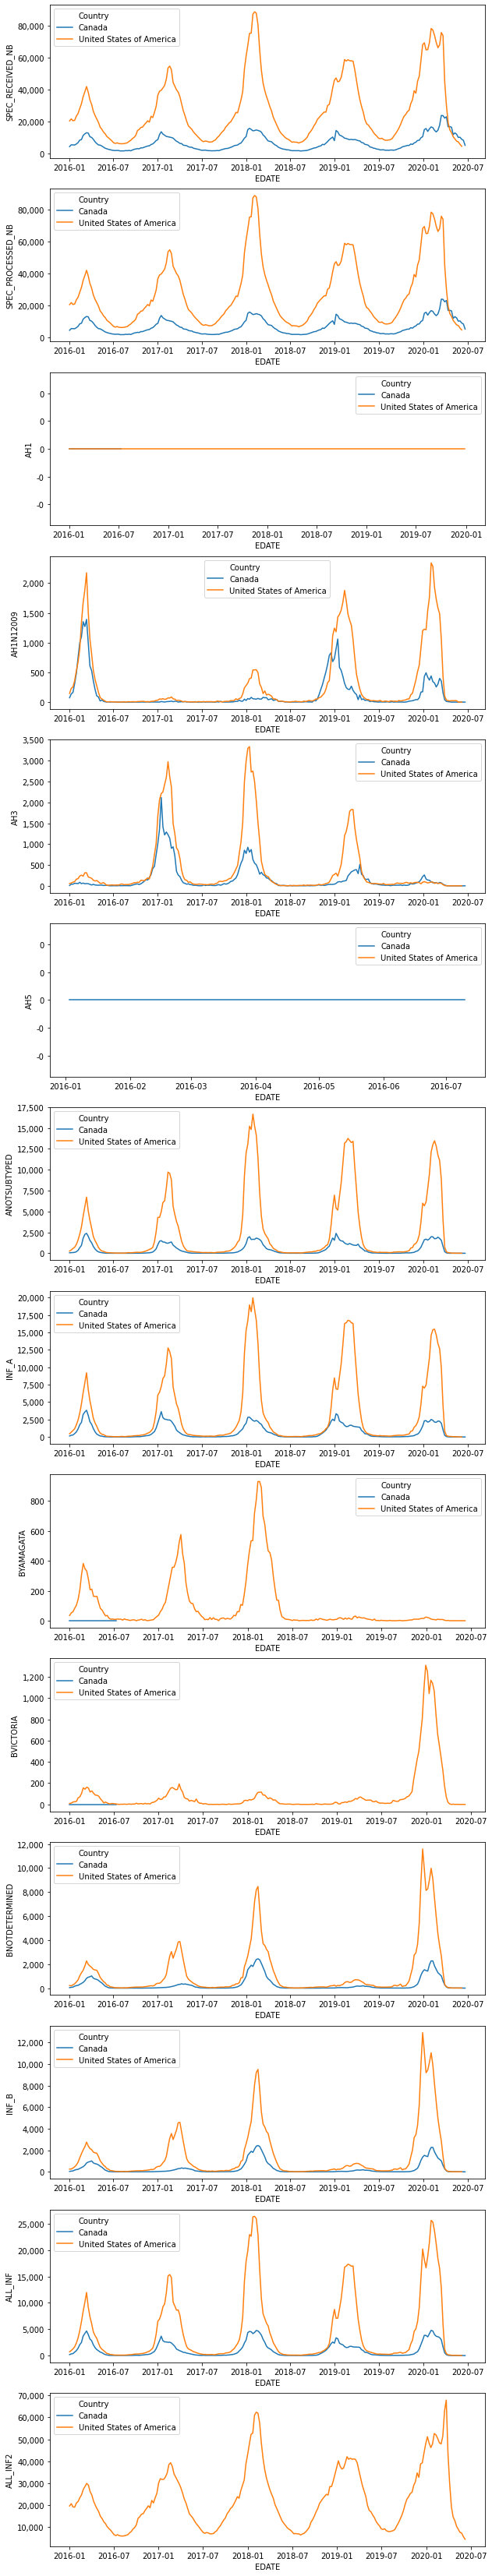

In [146]:
fig, ax = plt.subplots(ncols=1, nrows=len(numerics), figsize=(10, 60))
ax.ravel()
for i, col in enumerate(numerics):
    print(col)
    p = sns.lineplot(x=data.index, y=data[col], hue=data['Country'], ax=ax[i])
    p.set_yticklabels([f'{y:,.0f}' for y in p.get_yticks()])

#### Aggregation By Country

Since the time series for Canada and the US are highly correlated - aggregating them together will provide more data for the analysis. Bermuda is being dropped due to a lack of obeservations.

***TODO: SHOW CCF OF BOTH?***

In [147]:
time_series_train = train_data.groupby(train_data.index)[['ALL_INF']].sum()
time_series_test = test_data.groupby(test_data.index)[['ALL_INF']].sum()
#time_series_lag = (time_series - time_series.shift(52)).dropna()
#time_series_lag

## [Statsmodels Time Series Analysis]('https://www.statsmodels.org/stable/tsa.html')

- Let's explore the autocorrelation (**ACF**) and partial autocorrelation (**PACF**) structures of each our independent variables. 

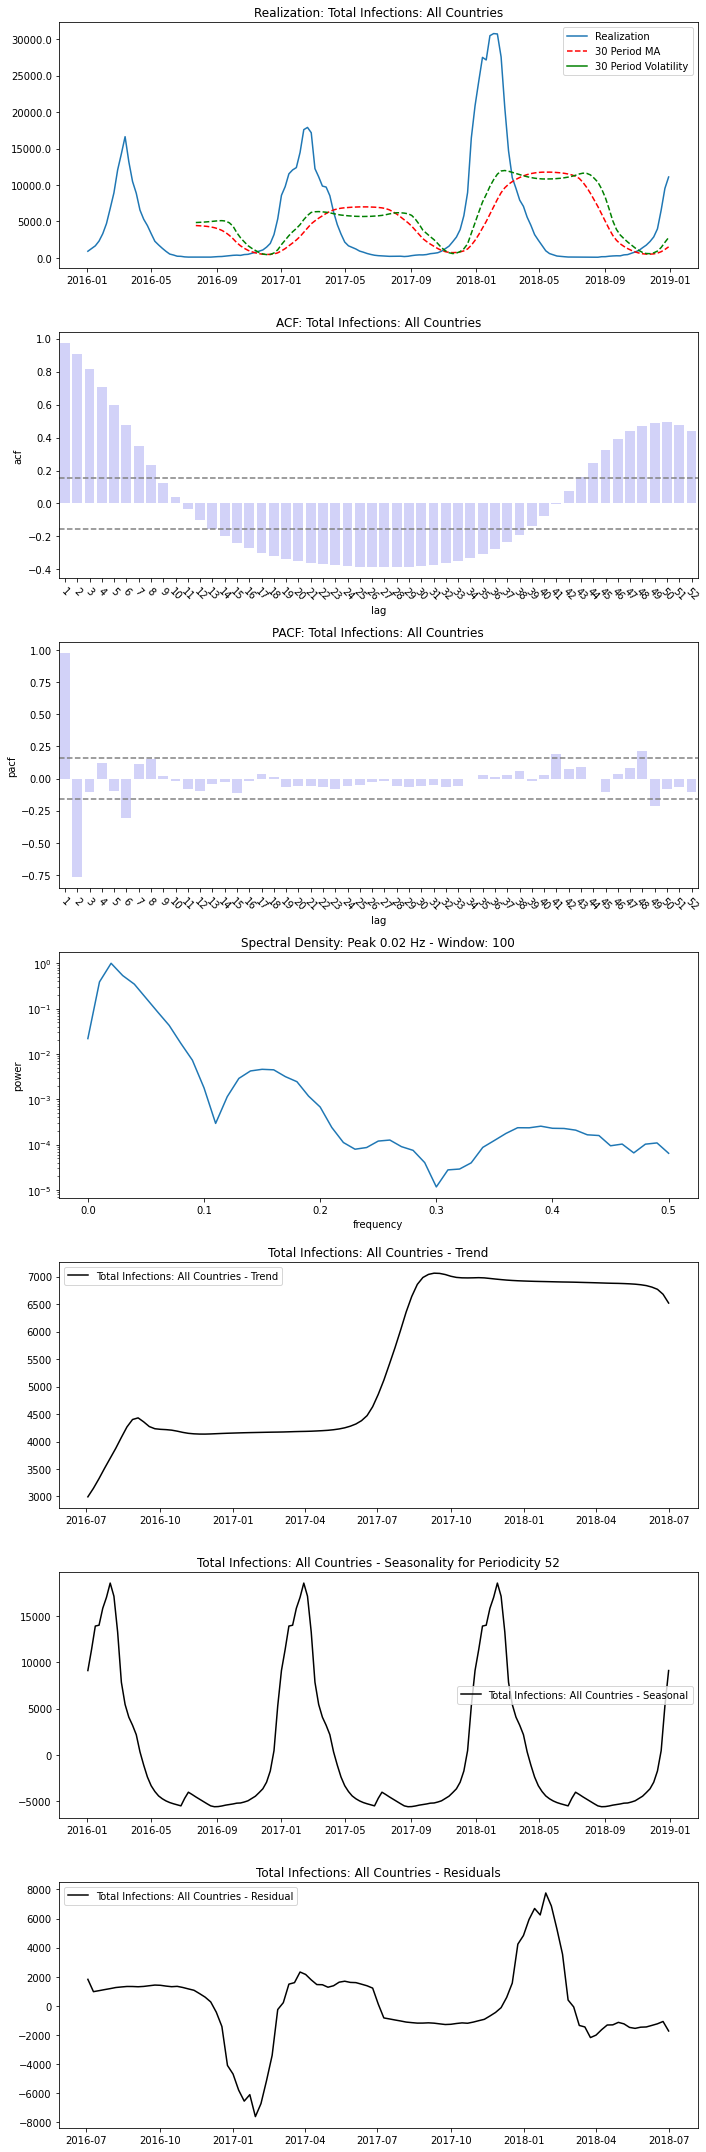

In [152]:
decomp = visualize_time_series(time_series_train['ALL_INF'], name='Total Infections: All Countries', rolling=30)

***ACF*** 

The ACF for our realization shows strong evidence of strong, positive autocorrelations across the first 8 lags and then switches to slightly less strong, negative correlations from lag 12 - lag 39. Finally, exhibiting strong, positive autocorrelations again at lags 44-52. This is entirely expected given that the data is sampled on a weekly basis and should be strongly correlated year over year. The negative autocorrelations show that there is strong tendencies towards reverting

***PACF***

From the PACF, evidence of a lull period is clear. Between lags 8 and 44, correlations drop below our signficance level indicating that there is a 36 week period (roughly 9 months) where there is little to no activity (the negtive correlations indicating that values are expected to be lower than they were in the past). This matches to what is shown in the realization - spikes in infection rates, followed by extended periods of inactivity.

***Spectral Density***

From the spectral density chart, this time series most likely has an AR component with a value of p greater than 1 since there is no way to observer multiple system frequencies between 0 and 0.5 for p < 2. AR(1) processes have system frequencies of 0 or 0.5. The strong peak at approximately 0.019 Hz shows that a seasonal component with a periodicity of 52 is highly likely.  

***Trend***

Strong evidence of an increasing trend towards the end of 2017 leading into the flu season of 2018. 

***Seasonality***

The seasonal decomposition predicts roughly 15k cases per season on average. It underestimates the spike in 2018 by approximately 8k cases and overstates the 2017 season by roughly the same amount.

***Residuals***

The residuals of our seasonal decomposition appear to be roughly normal but potentially bi-modal.

             resid
count   105.000000
mean     76.843997
std    2674.985957
min   -7600.526196
25%   -1231.579080
50%     128.186945
75%    1385.267073
max    7754.214189


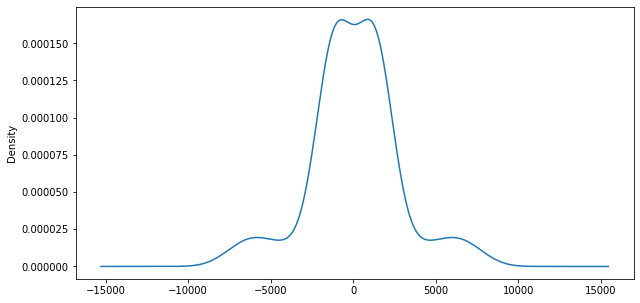

In [153]:
plt.figure(figsize=(10,5))
decomp.resid.plot(kind='kde')
print(pd.DataFrame(decomp.resid).describe())

In [157]:
aic_fit, bic_fit, seasonal_fit = fit_time_series(time_series_train)

AIC selects: AR(6) MA(2)
BIC selects: AR(2) MA(2)


In [158]:
aic_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ALL_INF   No. Observations:                  157
Model:                 ARIMA(6, 0, 2)   Log Likelihood               -1307.252
Date:                Tue, 30 Jun 2020   AIC                           2632.504
Time:                        19:58:23   BIC                           2660.010
Sample:                    01-03-2016   HQIC                          2643.676
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5025      0.282      5.337      0.000       0.951       2.054
ar.L2         -0.5100      0.478     -1.068      0.286      -1.446       0.426
ar.L3         -0.0373      0.607     -0.061      0.951      -1.227       1.152
ar.L4         -0.1091      0.303     -0.360      0.719      -0.703       0.484
ar.L5          0.3493      0.162      2.152      0.031       0.031       0.667
ar.L6         -0.2470      0.104     -2.384      0.017      -0.450      -0.044
ma.L1          0.1885      0.306      0.616      0.538      -0.411       0.788
ma.L2          0.3447      0.373      0.925      0.355      -0.386       1.076
sigma2      1.026e+06   5.89e+04     17.429      0.000    9.11e+05    1.14e+06
===================================================================================
Ljung-Box (Q):                       10.55   Jarque-Bera (JB):               502.97
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.16
Prob(H) (two-sided):                  0.67   Kurtosis:                        11.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
bic_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ALL_INF   No. Observations:                  157
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1311.649
Date:                Tue, 30 Jun 2020   AIC                           2633.297
Time:                        19:58:49   BIC                           2648.578
Sample:                    01-03-2016   HQIC                          2639.503
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5032      0.060     25.137      0.000       1.386       1.620
ar.L2         -0.5439      0.059     -9.177      0.000      -0.660      -0.428
ma.L1          0.1956      0.079      2.473      0.013       0.041       0.351
ma.L2          0.4489      0.049      9.223      0.000       0.354       0.544
sigma2      1.021e+06   5.59e+04     18.264      0.000    9.11e+05    1.13e+06
===================================================================================
Ljung-Box (Q):                       21.06   Jarque-Bera (JB):               434.99
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.40
Prob(H) (two-sided):                  0.26   Kurtosis:                        11.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
seasonal_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                ALL_INF   No. Observations:                  157
Model:                          ARIMA   Log Likelihood               -1644.494
Date:                Tue, 30 Jun 2020   AIC                           3290.987
Time:                        19:58:23   BIC                           3294.043
Sample:                    01-03-2016   HQIC                          3292.228
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.337e+07   4.78e+06     15.338      0.000     6.4e+07    8.28e+07
===================================================================================
Ljung-Box (Q):                     1142.83   Jarque-Bera (JB):               184.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.30   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Evaluation

Each of our 3 candidate models will be evaluated on an out of sample 

***NB on predict and forecast functions in statsmodel.api***

https://stackoverflow.com/questions/45596492/statsmodels-arima-different-results-using-predict-and-forecast

### Train Test Split

- Use data from 2016-2018 as train set to build our models, we will then test on 2019 and 2020 to determine which model is our best fit. Our criterion for model efficacy will be **RSS** (residual sum of squared error)

$$y_{t}=\phi_{1}y_{t-1}+\ldots+\phi_{p}y_{t-p}+\theta_{1}\epsilon_{t-1}
           +\ldots+\theta_{q}\epsilon_{t-q}+\epsilon_{t}$$
           
$$ Where\ the\ \phi\ are\ the\ AR\ Frequencies\$$

$$ Where\ the\ \theta\ are\ the\ MA\ Frequencies\$$
